In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import itertools

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, utils
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf

In [2]:
# Load dataset
data_dir = "./Bone Break Classification"

In [3]:
train_data = image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    seed=40,
    image_size=(256, 256),
    batch_size=64,
    color_mode="rgb"
)

validation_data = image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    shuffle=True,
    seed=42,
    image_size=(256, 256),
    batch_size=64,
    color_mode="rgb"
)

class_names = train_data.class_names
NUM_CLASSES = len(class_names)
print("Class names:", class_names)

Found 1129 files belonging to 10 classes.
Using 1017 files for training.
Found 1129 files belonging to 10 classes.
Using 112 files for validation.
Class names: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [4]:
def preprocess_for_model(img):
    """Preprocessing for the model (using EfficientNetB3)."""
    img = tf.cast(img, tf.float32)
    return preprocess_input(img)

def preprocess_for_display(img):
    """Preprocessing for image display to keep original colors."""
    img = tf.cast(img, tf.float32) / 255.0
    return img

In [5]:
train_dataset = train_data.map(lambda x, y: (preprocess_for_model(x), y))
val_dataset = validation_data.map(lambda x, y: (preprocess_for_model(x), y))
display_dataset = train_data.map(lambda x, y: (preprocess_for_display(x), y))

In [6]:
def dataset_to_numpy(dataset):
    x_data, y_data = [], []
    for images, labels in dataset:
        x_data.append(images.numpy())
        y_data.append(labels.numpy())
    return np.concatenate(x_data, axis=0), np.concatenate(y_data, axis=0)

In [7]:
x_train, y_train = dataset_to_numpy(train_dataset)
x_val, y_val = dataset_to_numpy(val_dataset)
x_display, y_display = dataset_to_numpy(display_dataset)

print("Shape of y_train before squeeze:", y_train.shape)
print("Shape of y_val before squeeze:", y_val.shape)

Shape of y_train before squeeze: (1017,)
Shape of y_val before squeeze: (112,)


In [8]:
y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)

print("Shape of y_train after squeeze:", y_train.shape)
print("Shape of y_val after squeeze:", y_val.shape)

Shape of y_train after squeeze: (1017,)
Shape of y_val after squeeze: (112,)


In [9]:
y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_val = utils.to_categorical(y_val, NUM_CLASSES)

print("Shape of y_train after one-hot encoding:", y_train.shape)
print("Shape of y_val after one-hot encoding:", y_val.shape)


Shape of y_train after one-hot encoding: (1017, 10)
Shape of y_val after one-hot encoding: (112, 10)


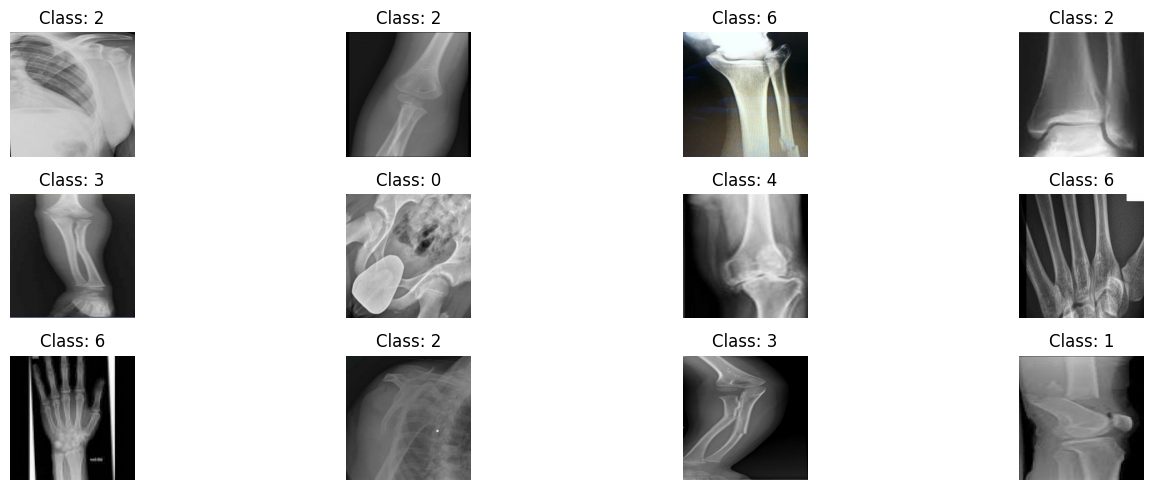

In [10]:
def display(images, labels, n=10, size=(15, 5)):
    indices = np.random.choice(len(images), n, replace=False)
    num_images_per_row = 4
    num_rows = (n + num_images_per_row - 1) // num_images_per_row
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=size)
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        img = images[idx]
        if np.max(img) <= 1.0:
            img_disp = (img * 255).astype("uint8")
        else:
            img_disp = img.astype("uint8")
        if img_disp.shape[-1] == 3:
            img_disp = img_disp[..., ::-1]
        axes[i].imshow(img_disp)
        axes[i].set_title(f'Class: {labels[idx]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

display(x_display, y_display, n=12)

In [11]:
def build_fusion_model(input_shape=(256, 256, 3), num_classes=NUM_CLASSES):
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # EfficientNet branch
    efficientnet = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )
    
    # Freeze early layers
    for layer in efficientnet.layers[:100]:
        layer.trainable = False
    
    # Get EfficientNet features
    x_eff = efficientnet.output
    x_eff = layers.GlobalAveragePooling2D()(x_eff)
    x_eff = layers.BatchNormalization()(x_eff)
    x_eff = layers.Dense(256, activation='relu')(x_eff)
    x_eff = layers.Dropout(0.3)(x_eff)
    
    # Simple transformer-inspired attention branch
    # Extract features using convolution with smaller patches
    x_vit = layers.Conv2D(
        filters=128,
        kernel_size=(16, 16),
        strides=(8, 8),
        padding="same"
    )(inputs)

    # Shape information for reshaping
    _, h, w, c = x_vit.shape
    
    # Reshape to sequence for attention
    x_vit = layers.Reshape((h * w, c))(x_vit)
    
    # Add positional embedding
    pos_embed = layers.Embedding(
        input_dim=h * w,
        output_dim=c
    )(tf.range(start=0, limit=h * w, delta=1))
    x_vit = x_vit + pos_embed
    
    # Self-attention mechanism
    x_vit = layers.LayerNormalization(epsilon=1e-6)(x_vit)
    attn_output = layers.MultiHeadAttention(
        num_heads=8,
        key_dim=64
    )(x_vit, x_vit)
    x_vit = layers.Add()([attn_output, x_vit])
    
    # Second transformer block
    x_vit = layers.LayerNormalization(epsilon=1e-6)(x_vit)
    attn_output = layers.MultiHeadAttention(
        num_heads=8,
        key_dim=64
    )(x_vit, x_vit)
    x_vit = layers.Add()([attn_output, x_vit])

    # MLP block
    x_vit = layers.LayerNormalization(epsilon=1e-6)(x_vit)
    x_vit = layers.Dense(256, activation=tf.nn.gelu)(x_vit)
    x_vit = layers.Dropout(0.1)(x_vit)
    x_vit = layers.Dense(128, activation=tf.nn.gelu)(x_vit)
    
    # Global pooling for transformer branch
    x_vit = layers.GlobalAveragePooling1D()(x_vit)
    x_vit = layers.BatchNormalization()(x_vit)
    x_vit = layers.Dense(256, activation='relu')(x_vit)
    x_vit = layers.Dropout(0.3)(x_vit)
    
    # Fusion of features
    fusion = layers.Concatenate()([x_eff, x_vit])
    fusion = layers.BatchNormalization()(fusion)
    fusion = layers.Dense(512, activation='relu')(fusion)
    fusion = layers.Dropout(0.5)(fusion)
    fusion = layers.Dense(256, activation='relu')(fusion)
    fusion = layers.Dropout(0.3)(fusion)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(fusion)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
# Create model
fusion_model = build_fusion_model()
fusion_model.summary()
import json

with open("class_names.json", "w") as f:
    json.dump(class_names, f)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        960 │ block1a_se_excit

 Total params: 12,308,025 (46.95 MB)

 Trainable params: 12,096,080 (46.14 MB)

 Non-trainable params: 211,945 (827.91 KB)

In [13]:
# Use fixed learning rate instead of scheduler
initial_learning_rate = 0.0001
opt = optimizers.Adam(learning_rate=initial_learning_rate)

In [14]:
# Compile model
fusion_model.compile(
    optimizer=opt, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [15]:
# Early stopping and model checkpoint
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [16]:
# Use ReduceLROnPlateau instead of LearningRateSchedule
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

In [ ]:
# Train model
history = fusion_model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_val, y_val),
    shuffle=True,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 440s 11s/step - accuracy: 0.0983 - loss: 2.8732 - val_accuracy: 0.0804 - val_loss: 2.3080 - learning_rate: 1.0000e-04
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 349s 11s/step - accuracy: 0.1426 - loss: 2.5703 - val_accuracy: 0.1964 - val_loss: 2.2723 - learning_rate: 1.0000e-04
Epoch 3/100
 7/32 ━━━━━━━━━━━━━━━━━━━━ 4:44 11s/step - accuracy: 0.1480 - loss: 2.6264

In [ ]:
evaluation = fusion_model.evaluate(x_val, y_val)
print("Fusion model evaluation on validation data:", evaluation)

In [ ]:
# Predict probabilities and convert to classes
y_pred_probs = fusion_model.predict(x_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

In [ ]:
# Calculate metrics
acc = accuracy_score(y_true_classes, y_pred_classes)
prec = precision_score(y_true_classes, y_pred_classes, average='weighted')
rec = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
bal_acc = balanced_accuracy_score(y_true_classes, y_pred_classes)  # Balanced Accuracy

# Display results
print(f"\nAccuracy          : {acc:.4f}")
print(f"Precision         : {prec:.4f}")
print(f"Recall            : {rec:.4f}")
print(f"F1 Score          : {f1:.4f}")
print(f"Balanced Accuracy : {bal_acc:.4f}")  # Additional Balanced Accuracy

# Display classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Number of classes
n_classes = len(class_names)

# Binarize true labels (y_true_classes)
y_true = label_binarize(y_true_classes, classes=range(n_classes))

In [ ]:
# Initialize variables for ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC Curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate ROC Curve and AUC for micro average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# Plot ROC Curve
plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

# Plot ROC Curve for micro average
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

In [ ]:
# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
fusion_model.save("bone_break_cnn_model.keras")